# Assignment 3

This assignment was submitted to the class of 2021/1 for the course MO444 - Introduction to Machine Learning at Universidade Estadual de Campinas.

Its goal is to apply Evolutionary Algorithms and Reinforcement Learning methods to solve the Pac-Man game.

**Authors**
- Jonathan Nunes  
  146667  
  <j146667@dac.unicamp.br>

  Contributions: part II

- Lucas David  
  188972  
  <lucas.david@ic.unicamp.br>

  Contributions: part I

**Instructions**

Download the `pacman.zip` file and extract it into the location described by the `Config.pacman_lib_path` variable. For example: `/content/drive/MyDrive/libs/pacman`.
The code inside the Setup section will copy the `search` folder to the same directory containing this notebook.
The remaining sections will use the lib indirectly, by executing the python2.7 interpreter with `! python search/pacman.py ...`.

This notebook is better visualized on Colab, where helpers and unimportant sections are hidden.


**Links**
- Colab: [1R7YboPBEv35cZU5WuGEuN0QNmJrFvYIl](https://colab.research.google.com/drive/1R7YboPBEv35cZU5WuGEuN0QNmJrFvYIl?usp=sharing)

In [ ]:
#@title

IS_COLAB = 'google.colab' in str(get_ipython())

if IS_COLAB:
  from google.colab import drive
  drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
if IS_COLAB:
  base_dir = '/content/drive/MyDrive/datasets/MO444/assignment-3'
else:
  base_dir = '/home/ldavid/workspace/repos/mo444/assignment-3'

class Config:
  pacman_lib_path = base_dir+'/search'

  class evolutionary:
    jobs = 4

    class small_maze:
      
      training_games = 20000
      testing_games = 10

      config = dict(
        INITIAL_POPULATION=100,
        INITIAL_FEATURE_STRENGTH=2.0,
        MUTATION=0.1,
        MUTATION_STRENGTH=0.5,
        TESTS_PER_AGENT=5,
        RETEST_EVERY_GENERATION=False,
        MODEL_SAVED_AT = base_dir+'/checkpoints/ev/small',
        SEED=4124,
        VERBOSE=1
      )
    
    class medium_maze:
      training_games = 10000
      testing_games = 10

      config = dict(
        INITIAL_POPULATION=100,
        INITIAL_FEATURE_STRENGTH=2.0,
        MUTATION=0.1,
        MUTATION_STRENGTH=0.5,
        TESTS_PER_AGENT=5,
        RETEST_EVERY_GENERATION=False,
        MODEL_SAVED_AT = base_dir+'/checkpoints/ev/medium',
        SEED=4124,
        VERBOSE=1
      )
    
    class original_maze:
      training_games = 4600
      testing_games = 10

      config = dict(
        INITIAL_POPULATION=100,
        INITIAL_FEATURE_STRENGTH=2.0,
        MUTATION=0.1,
        MUTATION_STRENGTH=0.5,
        TESTS_PER_AGENT=5,
        RETEST_EVERY_GENERATION=False,
        MODEL_SAVED_AT = base_dir+'/checkpoints/ev/original',
        SEED=4124,
        VERBOSE=1
      )
  
  class rl:
    class test_maze:
      checkpoint = base_dir+'/checkpoints/rl/test'
      episodes = 50
      tests = 10
    
    class small_maze:
      checkpoint = base_dir+'/checkpoints/rl/small'
      episodes = 5000
      tests = 10
    
    class medium_maze:
      checkpoint = base_dir+'/checkpoints/rl/medium'
      episodes = 2000
      tests = 10
    
    class original_maze:
      checkpoint = base_dir+'/checkpoints/rl/original'
      episodes = 1000
      tests = 10

## Setup

In [ ]:
%%bash

pip -qq install tk
### CREATE VIRTUAL DISPLAY ###
apt-get install -y xvfb # Install X Virtual Frame Buffer

Reading package lists...
Building dependency tree...
Reading state information...
The following NEW packages will be installed:
  xvfb
0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
Need to get 784 kB of archives.
After this operation, 2,270 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.9 [784 kB]
Fetched 784 kB in 1s (1,031 kB/s)
Selecting previously unselected package xvfb.
(Reading database ... 160815 files and directories currently installed.)
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.9_amd64.deb ...
Unpacking xvfb (2:1.19.6-1ubuntu4.9) ...
Setting up xvfb (2:1.19.6-1ubuntu4.9) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [ ]:
import os
import json
import shutil

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
sns.set()

In [ ]:
search_path = Config.pacman_lib_path

! cp -r "$search_path" .
! cp -r search/layouts search/*Agents.py .

In [ ]:
# Checking game run

! python search/pacman.py --layout testMaze --pacman GoWestAgent -q

Pacman emerges victorious! Score: 503
Average Score: 503.0
Scores:        503.0
Win Rate:      1/1 (1.00)
Record:        Win


## Evolutionary Strategy

### Description

In this section, we describe our solution for the Pacman game using Evolutionary Algorithms.
We employed Genetic Algorithms to build our Evolutionary Agent,
and represent by a (state-features, actions) matrix that determines which action will be executed next.

#### Gene and Individual Representation

Individuals in this population are Pacman agents that can play the game.
We represent an agent's decision rationale as a linear process described by
a function similar of classifiers found in Neural Networks and Support Vector Machines (SVMs).

Let $o$ be the temporal step in the current sequential game Pacman, $x^o$ the set of features observed from the world, $l^o_i$ a boolean (0 or 1) vector indicating whether the action $i$ is valid during step $o$, and $W$ and $b$ learning weights. Then,

$$
\begin{align}
p_i^o &= \text{softmax}(x^o\cdot W+b)_i \\
a^o &= \text{argmax}_i(p^o \circ l^o_i)
\end{align}
$$

To simplify things, we leverage the reduced representation of linear transformations, in which the number $1$ is concatenated to the input feature vector and the bias term is represented within $W$:

$$
x\cdot W + b \equiv [x|1] \cdot \Bigg[\frac{W}{b}\Bigg]
$$

Which can be expressed in Python code as:

```python
class EvolutionaryAgent(Agent):
  ...

  def getAction(self, state):
    legal_action_mask = np.isin(self.ACTIONS, state.getLegalPacmanActions())
    previ_action_mask = np.isin(self.ACTIONS, [self.previous_action])

    x = extract_features_from(state, previous_action_mask, legal_action_mask)
    y = np.matmul(x, self.w)
    y = np.exp(y) / sum(np.exp(y))
    y = y * legal_action_mask

    choice = self.ACTIONS[y.argmax()]
```


#### Features and Actions

Pacman world is described as a *cols x rows* grid, in which the lower-left corner is the $(0, 0)$ point. Furthermore, the first and last rows and columns are always ocupied by walls. Thus valid positions $(y, x)$ for objects in the map are always greater or equal to $(1, 1$) and lower or equal to $(\text{cols}-1, \text{rows}-1)$.
For example, for the grid below:
```python
---------
|F      |
|    G P|
---------
```
Hence,

* Pacman is located at $P_{p} = (7, 1)$
* The food dot is located at $P_{f} = (2, 1)$
* The ghost is located at $P_{g} = (5, 1)$

Manhattan distance (or L1-norm) is used to compute distances between points of interest.
To simplify the representation of the problem, we opted to represent distances between the Pacman Agent and objects of interest by always taking Pacman's current position as point of reference.
Additionaly, We normalize these values by dividing them by $(\text{cols}-2, \text{rows}-2)$.
Therefore,

* Pacman is located at $R_{p} = (0, 0)$
* G is located at $R_{g} = (−0.29, 0)$
* F is located at $R_{f} = (−1, 0.5)$


The following features are extracted by observing the world:

- **food_h**: float, relative horizontal distance to closest food dot.  
- **food_v**: float, relative vertical distance to closest food dot.
- **capsule_h**: float, relative horizontal distance to closest capsule.
- **capsule_v**: float, relative vertical distance to closest capsule.
- **scary_ghost_h**: float, relative horizontal distance to closest harmful ghost.
- **scary_ghost_v**: float, relative vertical distance to closest harmful ghost.
- **scared_ghost_h**: float, relative horizontal distance to closest scared ghost.
- **scared_ghost_v**: float, relative vertical distance to closest scared ghost.
- **legal_north?** bool, whether is it legal to go North.
- **legal_south?** bool, whether is it legal to go South.
- **legal_east?** bool, whether is it legal to go East.
- **legal_west?** bool, whether is it legal to go West.
- **previous_north?** bool, whether North was the previous action.
- **previous_south?** bool, whether South was the previous action.
- **previous_east?** bool, whether East was the previous action.
- **previous_west?** bool, whether West was the previous action.
- **bias** int, always the constant $1$.


Four actions are considered, and are described below.
```python
ACTIONS = [Directions.NORTH, Directions.SOUTH, Directions.EAST, Directions.WEST]
```

#### Initial Population Generation

As individuals are entirely represented by action matrices $W$, generating an initial population is trivial.
Let $N_0, F, A\in\mathbb{N}^+$ be the number of individuals in the initial population, the number of features observed from the world and the number of actions available to the player, respectively.
Let $V_0\in\mathbb{R}^+$ be the maximum feature variation allowed --- a hyperparameter defined during search ---. Then, the initial population is defined as:

$$P = \{W^i = [w^i_{lm}]_{F\times A}, \forall i\in[0,N_0) \}$$
where $w^i_{lm} = 2V_0(p_{lm} - 0.5)$ and $p_{lm} \sim U(0, 1)$ is a number drawn from a uniformly random distribution.

This is represented in Python code as:

```python
class EvolutionPool(object):
  ...

  def generate(self):
    self.individuals = (2 * (np.random.rand(self.samples, *self.shape) - 0.5) * INITIAL_FEATURE_STRENGTH)
    self.scores = np.full(self.samples, -np.inf)
    self.steps = np.zeros(self.samples)
    self.evaluations = dict()
```

#### Evaluating Individuals

An evaluation of an individual $W^i$ consists of playing the game until its end, in which either Pacman wins by eating all food dots or dies when it comes in contact with one of the Ghosts. In this moment, the score associated with the current state of the game is added to the set of evaluations undertook by $W^i$.

As the Pacman game has an associated random factor, inducing an uncertain behavior from ghosts across maps, final game scores sometimes do not reflect the true performance of an individual. To circumvent this uncertainty, we evaluate each individual $W^i$ multiple times. We found 5 evaluations per individual to be a good compromise between training time and stability.

Once an individual is evaluated 5 times, its fitness value (defined as the mean among its evaluation scores) is compared with the highest solution candidate $W^\star$ found so far. If $W^i$ presents a higher fitness value than $W^\star$, we redefine the solution candidate in order to restored it during test time.

#### Natural Selection

Once all individuals in the initial population have been evaluated, selection occurs. We perform selection **before** reproduction, as it showed faster covergence in early testings of our solution.

We utilize **Steady State** to select individuals, in which half of the population --- the one with lower fitness score --- is killed and replaced with the same number of descendents during the reproduction stage.

Selection can be translated into Python code with the following snippet:
```python
  def selection(self):
    samples = len(self.scores) // 2
    ids = np.argsort(self.scores)[::-1]
    selected = ids[:samples]
    self.individuals = self.individuals[selected]
    self.scores = self.scores[selected]
    self.steps = self.steps[selected]
    self.evaluations = {ind: score for ind, score in enumerate(self.scores)}
```

#### Reproduction

**Roulette Selection** is used to determine which individuals will be used in crossover. The probability of an individual being selected for breeding is proportional to its fitness, and they are drawn from the population set with replacement.
A small $\epsilon$ is added to each fitness value to guarantee every individual has a chance of breeding:

```python
  def roulette(self, individuals):
    p = self.scores - self.scores.min() + 1e-7
    pairs = np.random.choice(len(individuals), size=2 * len(individuals), p=p / p.sum())

    a, b = pairs[:len(pairs) // 2], pairs[len(pairs) // 2:]
    return individuals[a], individuals[b]
```

Multi-point crossover is used here. Each individual has a 50% chance of receiving a gene from either parent:

```python
  def crossover(self, a, b):
    s = np.random.rand(*a.shape) > 0.5
    return s * a + ~s * b
```

Finally, mutation is controlled by a mutation probability factor $p^i_{lm}$ and mutation strength factor $V_m$, in which a gene $[w^i_{lm}]$ is mutated with the addition of a random factor $V_m U(0, 1)$, with probability $p^i_{lm}$:

```python
  def mutate(self, individuals):
    r = np.random.rand(*individuals.shape) <= MUTATION
    m = 2 * (np.random.rand(*individuals.shape) - 0.5) * MUTATION_STRENGTH

    return individuals + r * m
```

### Genetic Algorithm-Based Agent

In [ ]:
%%file EvolutionaryAgents.py

import json
import os

import numpy as np
import pandas as pd
from game import Agent, Directions
from util import manhattanDistance


# region Global Configuration

config_file = os.environ.get('CONFIG_FILE')

if config_file:
  with open(config_file) as f:
    config = json.load(f)

  print('[root] loading config file %s' % config_file)
else:
  config = dict()

MAX_SCARED_TIME          = config.get('MAX_SCARED_TIME', 40)
INITIAL_POPULATION       = config.get('INITIAL_POPULATION', 100)
INITIAL_FEATURE_STRENGTH = config.get('INITIAL_FEATURE_STRENGTH', 2.)
MUTATION                 = config.get('MUTATION', 0.05)
MUTATION_STRENGTH        = config.get('MUTATION_STRENGTH', 0.5)
TESTS_PER_AGENT          = config.get('TESTS_PER_AGENT', 5)
RETEST_EVERY_GENERATION  = config.get('RETEST_EVERY_GENERATION', False)
VERBOSE                  = int(config.get('VERBOSE', 1))
MODEL_SAVED_AT           = config.get('MODEL_SAVED_AT', 'checkpoints/ev/epochs-10000-pop-100-f-str-2-mut-0.05-mut-str-0.5-tests-5/')

seed = config.get('SEED')

if seed:
  print('[root] seeding %i' % seed)
  np.random.seed(seed)

# endregion


class History(object):
  def __init__(self):
    self.data = {}

  def update(self, key, value):
    if key not in self.data:
      self.data[key] = []
    self.data[key].append(value)

  def __getitem__(self, item):
    return self.data[item]

  def items(self):
    return self.data.items()

  def as_pandas(self):
    return pd.DataFrame(self.data)


class EvolutionPool(object):
  def __init__(
      self,
      shape,
      samples=INITIAL_POPULATION,
  ):
    self.shape = shape
    self.samples = samples
    self.individuals = None
    self.scores = None
    self.steps = None
    self.evaluations = None
    self.total_evaluations = 0
    self.generations = 0
    self.current_ind = 0
    self.fittest_idx = -1
    self.fittest_score = -np.inf
    self.fittest_weights = None

    self.history = History()
    self.generate()

  def generate(self):
    if VERBOSE > 1: print('[EvolutionPool] generating an initial population of %i' % self.samples)
    self.individuals = (2 * (np.random.rand(self.samples, *self.shape) - 0.5) * INITIAL_FEATURE_STRENGTH)
    self.scores = np.full(self.samples, -np.inf)
    self.steps = np.zeros(self.samples)
    self.evaluations = dict()

  def training(self, epoch):
    if self.current_ind >= len(self.individuals):
      self.track_generation(epoch)
      self.selection()
      self.reproduce()

    return self.current_ind, self.individuals[self.current_ind]

  def evaluate(self, ind, score, steps, epoch):
    if ind not in self.evaluations:  # First eval
      self.evaluations[ind] = []

    self.evaluations[ind].append(score)
    self.steps[ind] += steps
    self.total_evaluations += 1

    if len(self.evaluations[ind]) >= TESTS_PER_AGENT:
      self.scores[ind] = np.mean(self.evaluations[ind])
      self.steps[ind] /= TESTS_PER_AGENT

      if self.scores[ind] > self.fittest_score:
        if VERBOSE > 1: print('[EvolutionPool] fittest candidate found at epoch %i [score=%s]' % (epoch, self.scores[ind]))
        self.fittest_idx = ind
        self.fittest_score = self.scores[ind]
        self.fittest_weights = self.individuals[ind]

      # No more tests for this individual.
      self.current_ind += 1

    return self.scores[ind]

  def track_generation(self, epoch):
    if VERBOSE > 1: print('[EvolutionPool] Epoch=%i' % epoch)

    metrics = (
      ('generation', self.generations),
      ('scores', self.scores.copy()),
      ('scores_max', self.scores.max()),
      ('scores_min', self.scores.min()),
      ('scores_avg', self.scores.mean()),
      ('steps_max', self.steps.max()),
      ('steps_min', self.steps.min()),
      ('steps_avg', self.steps.mean()),
    )

    for k, v in metrics:
      self.history.update(k, v)
      if isinstance(v, np.ndarray): v = v.round()[:5]
      if VERBOSE > 2: print('   %s=%s' % (k, v))

  def reproduce(self):
    old_population_count = len(self.individuals)

    a, b = self.roulette(self.individuals)
    offspring = self.crossover(a, b)
    offspring = self.mutate(offspring)
    self.individuals = np.concatenate((self.individuals, offspring), axis=0)
    self.scores = np.concatenate((self.scores, np.full(len(offspring), -np.inf)))
    self.steps = np.concatenate((self.steps, np.full(len(offspring), 0)))

    self.current_ind = 0 if RETEST_EVERY_GENERATION else old_population_count
    self.generations += 1

  def roulette(self, individuals):
    p = self.scores - self.scores.min() + 1e-7
    pairs = np.random.choice(len(individuals), size=2 * len(individuals), p=p / p.sum())

    a, b = pairs[:len(pairs) // 2], pairs[len(pairs) // 2:]
    return individuals[a], individuals[b]

  def crossover(self, a, b):
    s = np.random.rand(*a.shape) > 0.5
    return s * a + ~s * b

  def mutate(self, individuals):
    r = np.random.rand(*individuals.shape) <= MUTATION
    m = 2 * (np.random.rand(*individuals.shape) - 0.5) * MUTATION_STRENGTH

    return individuals + r * m

  def selection(self):
    samples = len(self.scores) // 2
    ids = np.argsort(self.scores)[::-1]
    selected = ids[:samples]
    self.individuals = self.individuals[selected]
    self.scores = self.scores[selected]
    self.steps = self.steps[selected]
    self.evaluations = {ind: score for ind, score in enumerate(self.scores)}


class EvolutionaryAgent(Agent):
  ACTIONS = [Directions.NORTH, Directions.SOUTH, Directions.EAST, Directions.WEST]
  FEATURES = [
    'food_h', 'food_v', 'capsule_h', 'capsule_v',
    'scary_ghost_h', 'scary_ghost_v', 'scared_ghost_h', 'scared_ghost_v',
    'legal_north?', 'legal_south?', 'legal_east?', 'legal_west?',
    'previous_north?', 'previous_south?', 'previous_east?', 'previous_west?',
    'bias',
  ]

  def __init__(
      self,
      numTraining=None,
      **kwargs
  ):
    self.epoch = 1
    self.steps = 0
    self.numTraining = numTraining
    self.previous_action = Directions.EAST

    if numTraining:
      if VERBOSE: print('[EvolutionaryAgent] %s epochs will be used for training.' % numTraining)

      self.p = EvolutionPool(
        shape=(len(self.FEATURES), len(self.ACTIONS))
      )

      self.ind, self.w = self.p.training(self.epoch)
    else:
      self.p = None
      self.ind, self.w = -1, load_model(MODEL_SAVED_AT)

  def getAction(self, state):
    previ_actions_mask = np.isin(self.ACTIONS, [self.previous_action])
    legal_actions_mask = np.isin(self.ACTIONS, state.getLegalPacmanActions())

    x = extract_features_from(state, previ_actions_mask, legal_actions_mask)
    y = np.matmul(x, self.w)
    y = np.exp(y) / sum(np.exp(y))
    y = y * legal_actions_mask

    # choice = np.random.choice(self.ACTIONS, p=y / y.sum())
    choice = self.ACTIONS[y.argmax()]

    self.previous_action = choice
    self.steps += 1

    return choice

  def final(self, state):
    if self.epoch < self.numTraining:
      self.p.evaluate(self.ind, state.getScore(), self.steps, self.epoch)
      self.ind, self.w = self.p.training(self.epoch)

    if self.epoch == self.numTraining and self.p.fittest_weights is not None:
      if VERBOSE: print('Restoring best weights [score=%.0f]' % self.p.fittest_score)

      self.w = self.p.fittest_weights
      save_model(self, MODEL_SAVED_AT)

    self.epoch += 1
    self.steps = 0


# region features

def extract_features_from(state, previous_actions, legal_actions):
  pp = state.getPacmanPosition()

  fm = np.asarray(state.getFood().data)
  fp = np.stack(np.where(fm)).T

  cols, rows = fm.shape
  cols, rows = cols-2, rows-2  # account for external walls.

  food, f_idx = distance_as_features(pp, fp, rows, cols)
  capsules, c_idx = distance_as_features(pp, state.getCapsules(), rows, cols)

  ghosts = state.getGhostStates()
  scary = [g for g in ghosts if g.scaredTimer <= 0]
  scared = [g for g in ghosts if g.scaredTimer > 0]

  scary_dist, _ = distance_as_features(pp, [g.getPosition() for g in scary], rows, cols)
  scared_dist, _ = distance_as_features(pp, [g.getPosition() for g in scared], rows, cols)

  return np.asarray(food + capsules + scary_dist + scared_dist
                    + legal_actions.tolist()
                    + previous_actions.tolist()
                    + [1])


def distance_as_features(pp, p, rows, cols):
  p = np.asarray(p)
  if not len(p):
    return [1, 1], -1  # max distance

  dists = manhattanDistance(p.T, pp)
  _idx = closest_idx(dists)
  d = p[_idx]
  v = (d - pp).astype('float') / [cols, rows]

  return v.tolist(), _idx


def closest_idx(d, deterministic=False):
  if deterministic:
    return d.argmin()

  indices, = np.where(d == d.min())
  return np.random.choice(indices)

# endregion


# region callbacks

def save_model(model, model_path):
  if VERBOSE: print('[EvolutionaryAgent] saving weights to %s' % model_path)

  try: os.makedirs(model_path)
  except: pass

  with open(os.path.join(model_path, 'weights.txt'), 'w') as f:
    json.dump(model.w.tolist(), f)

  model.p.history.as_pandas().to_csv(os.path.join(model_path, 'history.csv'), index=False)


def load_model(model_path):
  if VERBOSE: print('[EvolutionaryAgent] loading weights from %s' % model_path)

  with open(os.path.join(model_path, 'weights.txt')) as f:
    return np.asarray(json.load(f))

# endregion

Overwriting EvolutionaryAgents.py


In [ ]:
! cp EvolutionaryAgents.py search/EvolutionaryAgents.py

### Searching Parameters

In [ ]:
def train(map, epochs, config, config_path):
  with open(config_path, 'w') as f:
    json.dump(config, f)
  
  print('[Training] map=%s epochs=%i' % (map, epochs))

  ! CONFIG_FILE=$config_path    \
    python search/pacman.py     \
    --layout $map               \
    --pacman EvolutionaryAgent  \
    -n $epochs -x $epochs -q -f
  
  return config_path

def train_async(args):
  return train(*args)

In [ ]:
from math import ceil
from multiprocessing.pool import ThreadPool

def search(params, config, report_dir, jobs):
  """Run a training procedure for each configuration described in `params`, collecting its logs.

  Returns
  -------
  pd.DataFrame
    The evolution report.
  """

  tp_args = []

  for (epochs, initial_population, mutation, mutation_strength) in params:
    checkpoint = ('epochs=%s-initial_population=%s-mutation=%s-mutation_strength=%s'
                  % (epochs, initial_population, mutation, mutation_strength))
    checkpoint = os.path.join(report_dir, checkpoint)
    
    try: os.makedirs(checkpoint)
    except: pass

    c = config.copy()
    c.update(
      INITIAL_POPULATION=initial_population,
      MUTATION_STRENGTH=mutation_strength,
      MUTATION=mutation,
      MODEL_SAVED_AT=checkpoint,
      VERBOSE=1)

    tp_args.append((
      'smallClassic',
      epochs,
      c,
      os.path.join(checkpoint, 'config.json')
    ))

  if jobs > 1:
    tp = ThreadPool(processes=jobs)
    results = tp.map(train_async, tp_args)
    del tp
  else:
    results = [train_async(p) for p in tp_args]

  print('done: %s' % results)



def generations_to_epochs(g, initial_population=100, tests_per_individual=5):
  """Calculate how many epochs (games) are necessary for the EvolutionPool to spawn `g` generations.

  Parameters
  ----------
  g: int, the number of generations desired
  initial_population: int, the number of individuals in the evolution pool
  tests_per_individuals: int, the number of tests performed to evaluate each individual

  Returns
  -------
  int
    The number of epochs.
  """

  return int(ceil((1. + (g - 1.) / 2.) * initial_population*tests_per_individual))

In [ ]:
%%time

EPOCHS = Config.evolutionary.search_epochs

search(
  params=(
    # epochs, individuals, mutation, mutation_strength
    (generations_to_epochs(EPOCHS, 100), 100, 0.01, 0.5),
    (generations_to_epochs(EPOCHS, 100), 100, 0.05, 0.5),
    (generations_to_epochs(EPOCHS, 100), 100, 0.10, 0.5),
    (generations_to_epochs(EPOCHS, 100), 100, 0.05, 0.1),
    (generations_to_epochs(EPOCHS, 100), 100, 0.05, 0.25),
    (generations_to_epochs(EPOCHS, 100), 100, 0.05, 0.75),
  ),
  config=Config.evolutionary.small_maze.config,
  report_dir=Config.evolutionary.search_reports_dir,
  jobs=Config.evolutionary.jobs
)

[Training] map=smallClassic epochs=7750
[root] loading config file /checkpoints/ev/search/epochs=7750-initial_population=100-mutation=0.01-mutation_strength=0.5/config.json
[root] seeding 4124
[EvolutionaryAgent] 7750 epochs will be used for training.
Restoring best weights [score=218]
[EvolutionaryAgent] saving weights to /checkpoints/ev/search/epochs=7750-initial_population=100-mutation=0.01-mutation_strength=0.5
[Training] map=smallClassic epochs=7750
[root] loading config file /checkpoints/ev/search/epochs=7750-initial_population=100-mutation=0.05-mutation_strength=0.5/config.json
[root] seeding 4124
[EvolutionaryAgent] 7750 epochs will be used for training.
Restoring best weights [score=174]
[EvolutionaryAgent] saving weights to /checkpoints/ev/search/epochs=7750-initial_population=100-mutation=0.05-mutation_strength=0.5
[Training] map=smallClassic epochs=7750
[root] loading config file /checkpoints/ev/search/epochs=7750-initial_population=100-mutation=0.1-mutation_strength=0.5/co

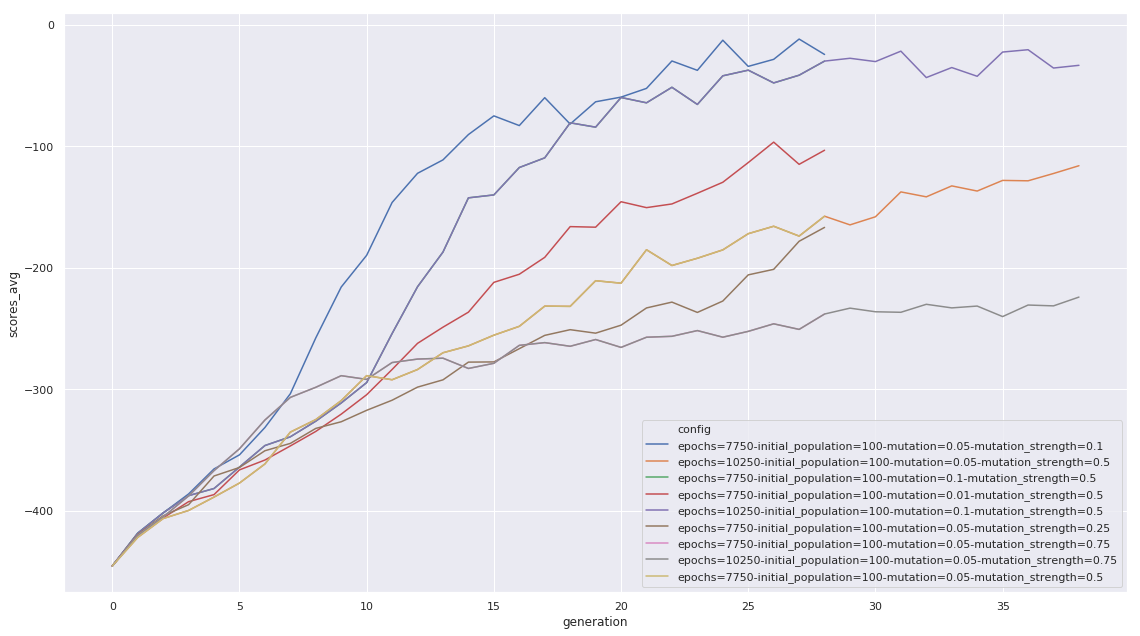

In [ ]:
#@title Impact of Parameters on Population Evolution

search_dir = Config.evolutionary.search_reports_dir

report = pd.concat([
  pd.read_csv(os.path.join(search_dir, config, 'history.csv')).assign(config=config)
  for config in os.listdir(search_dir)
  if 'history.csv' in os.listdir(os.path.join(search_dir, config))
])

plt.figure(figsize=(16, 9))
sns.lineplot(data=report, x='generation', y='scores_avg', hue='config')
plt.tight_layout();

It is possible to observe from the curves above that the parameters `initial-population=100`, `mutation=0.05` and `mutation-strength=0.1` induce a faster population convergence, which is not surpassed by other combination of parameters regardless of the generation considered.

As such, we opted to use these parameters in the following sections.

### Small Classic Maze

#### Training

In [ ]:
%%time

train(
  'smallClassic',
  Config.evolutionary.small_maze.training_games,
  Config.evolutionary.small_maze.config,
  'small-config.json'
)

[Training] map=smallClassic epochs=20000
[root] loading config file small-config.json
[root] seeding 4124
[EvolutionaryAgent] 20000 epochs will be used for training.
[EvolutionPool] generating an initial population of 100
[EvolutionPool] fittest candidate found [score=-469.8]
[EvolutionPool] fittest candidate found [score=-448.6]
[EvolutionPool] fittest candidate found [score=-432.0]
[EvolutionPool] fittest candidate found [score=-415.0]
[EvolutionPool] fittest candidate found [score=-410.8]
[EvolutionPool] fittest candidate found [score=-386.2]
[EvolutionPool] fittest candidate found [score=-374.8]
[EvolutionPool] fittest candidate found [score=-330.6]
[EvolutionPool] Epoch=500
[EvolutionPool] fittest candidate found [score=-245.4]
[EvolutionPool] Epoch=750
[EvolutionPool] Epoch=1000
[EvolutionPool] fittest candidate found [score=-190.2]
[EvolutionPool] Epoch=1250
[EvolutionPool] fittest candidate found [score=-103.8]
[EvolutionPool] Epoch=1500
[EvolutionPool] Epoch=1750
[EvolutionPoo

'small-config.json'

#### Evaluation

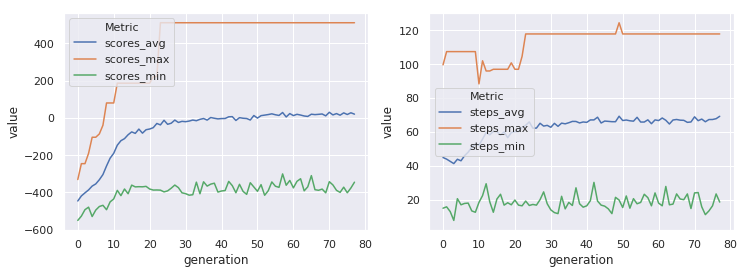

In [ ]:
#@title

history = pd.read_csv(os.path.join(
  Config.evolutionary.small_maze.config['MODEL_SAVED_AT'],
  'history.csv'))


plt.figure(figsize=(12, 4))
plt.subplot(121)
sns.lineplot(data=history.melt(id_vars='generation',
                               value_vars=['scores_avg', 'scores_max', 'scores_min'],
                               var_name='Metric'),
             x='generation', y='value', hue='Metric')
plt.subplot(122)
sns.lineplot(data=history.melt(id_vars='generation',
                               value_vars=['steps_avg', 'steps_max', 'steps_min'],
                               var_name='Metric'),
             x='generation', y='value', hue='Metric');

#### Playing Game

In [ ]:
! CONFIG_FILE=small-config.json     \
  python search/pacman.py           \
         --layout smallClassic      \
         --pacman EvolutionaryAgent \
         -n 20 -q -f

[root] loading config file small-config.json
[root] seeding 4124
[EvolutionaryAgent] loading weights from /content/drive/MyDrive/datasets/MO444/assignment-3/checkpoints/ev/small
Pacman died! Score: -446
Pacman died! Score: 304
Pacman died! Score: -394
Pacman died! Score: -446
Pacman died! Score: 159
Pacman died! Score: 57
Pacman died! Score: 89
Pacman died! Score: 238
Pacman died! Score: -130
Pacman died! Score: 198
Pacman died! Score: -340
Pacman died! Score: -410
Pacman died! Score: -9
Pacman died! Score: 205
Pacman died! Score: -410
Pacman died! Score: -184
Pacman died! Score: 69
Pacman died! Score: -446
Pacman died! Score: 242
Pacman died! Score: -446
Average Score: -105.0
Scores:        -446.0, 304.0, -394.0, -446.0, 159.0, 57.0, 89.0, 238.0, -130.0, 198.0, -340.0, -410.0, -9.0, 205.0, -410.0, -184.0, 69.0, -446.0, 242.0, -446.0
Win Rate:      0/20 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss, Loss, Loss, Loss, Loss, Loss, Loss, Loss, Loss, Loss, Loss, Loss, Loss, Loss, Loss

### Medium Classic Maze

##### Training

In [ ]:
%%time

train(
  'mediumClassic',
  Config.evolutionary.medium_maze.training_games,
  Config.evolutionary.medium_maze.config,
  'medium-config.json'
)

[Training] map=mediumClassic epochs=10000
[root] loading config file medium-config.json
[root] seeding 4124
[EvolutionaryAgent] 10000 epochs will be used for training.
[EvolutionPool] generating an initial population of 100
[EvolutionPool] fittest candidate found [score=-501.2]
[EvolutionPool] fittest candidate found [score=-453.4]
[EvolutionPool] fittest candidate found [score=-306.0]
[EvolutionPool] fittest candidate found [score=-264.4]
[EvolutionPool] Epoch=500
[EvolutionPool] fittest candidate found [score=-209.6]
[EvolutionPool] Epoch=750
[EvolutionPool] Epoch=1000
[EvolutionPool] Epoch=1250
[EvolutionPool] fittest candidate found [score=-48.8]
[EvolutionPool] Epoch=1500
[EvolutionPool] Epoch=1750
[EvolutionPool] fittest candidate found [score=80.4]
[EvolutionPool] Epoch=2000
[EvolutionPool] fittest candidate found [score=126.2]
[EvolutionPool] Epoch=2250
[EvolutionPool] Epoch=2500
[EvolutionPool] fittest candidate found [score=158.4]
[EvolutionPool] fittest candidate found [scor

'medium-config.json'

#### Evaluation

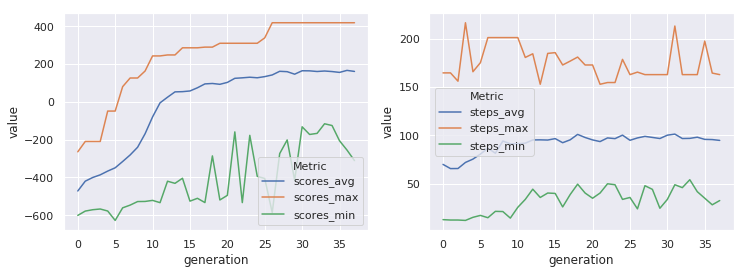

In [ ]:
#@title

history = pd.read_csv(os.path.join(
  Config.evolutionary.medium_maze.config['MODEL_SAVED_AT'],
  'history.csv'))


plt.figure(figsize=(12, 4))
plt.subplot(121)
sns.lineplot(data=history.melt(id_vars='generation',
                               value_vars=['scores_avg', 'scores_max', 'scores_min'],
                               var_name='Metric'),
             x='generation', y='value', hue='Metric')
plt.subplot(122)
sns.lineplot(data=history.melt(id_vars='generation',
                               value_vars=['steps_avg', 'steps_max', 'steps_min'],
                               var_name='Metric'),
             x='generation', y='value', hue='Metric');

#### Playing Game

In [ ]:
! CONFIG_FILE=medium-config.json     \
  python search/pacman.py           \
         --layout mediumClassic      \
         --pacman EvolutionaryAgent \
         -n 10 -q -f

[root] loading config file medium-config.json
[root] seeding 4124
[EvolutionaryAgent] loading weights from /content/drive/MyDrive/datasets/MO444/assignment-3/checkpoints/ev/medium
Pacman died! Score: 156
Pacman died! Score: 289
Pacman died! Score: -394
Pacman died! Score: 113
Pacman died! Score: 195
Pacman died! Score: -94
Pacman died! Score: 521
Pacman died! Score: 133
Pacman died! Score: 127
Pacman died! Score: 209
Average Score: 125.5
Scores:        156.0, 289.0, -394.0, 113.0, 195.0, -94.0, 521.0, 133.0, 127.0, 209.0
Win Rate:      0/10 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss, Loss, Loss, Loss, Loss, Loss


### Original Classic Maze

##### Training

In [ ]:
%%time

train(
  'originalClassic',
  Config.evolutionary.original_maze.training_games,
  Config.evolutionary.original_maze.config,
  'original-config.json'
)

[Training] map=originalClassic epochs=4600
[root] loading config file original-config.json
[root] seeding 4124
[EvolutionaryAgent] 4600 epochs will be used for training.
[EvolutionPool] generating an initial population of 100
[EvolutionPool] fittest candidate found at epoch 5 [score=-490.6]
[EvolutionPool] fittest candidate found at epoch 10 [score=-331.8]
[EvolutionPool] fittest candidate found at epoch 65 [score=-158.0]
[EvolutionPool] fittest candidate found at epoch 255 [score=64.0]
[EvolutionPool] Epoch=500
[EvolutionPool] Epoch=750
[EvolutionPool] Epoch=1000
[EvolutionPool] Epoch=1250
[EvolutionPool] Epoch=1500
[EvolutionPool] fittest candidate found at epoch 1570 [score=112.2]
[EvolutionPool] Epoch=1750
[EvolutionPool] fittest candidate found at epoch 1860 [score=140.0]
[EvolutionPool] fittest candidate found at epoch 1905 [score=302.2]
[EvolutionPool] Epoch=2000
[EvolutionPool] Epoch=2250
[EvolutionPool] Epoch=2500
[EvolutionPool] fittest candidate found at epoch 2690 [score=32

'original-config.json'

#### Evaluation



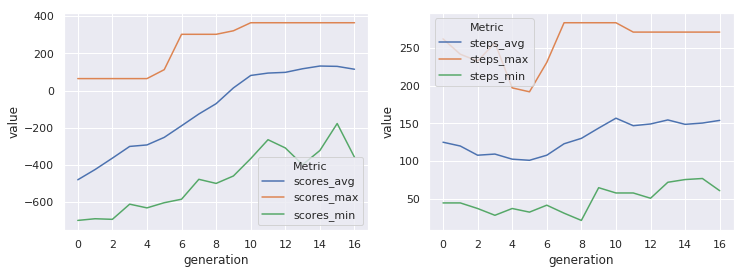

In [ ]:
#@title

history = pd.read_csv(os.path.join(
  Config.evolutionary.original_maze.config['MODEL_SAVED_AT'],
  'history.csv'))


plt.figure(figsize=(12, 4))
plt.subplot(121)
sns.lineplot(data=history.melt(id_vars='generation',
                               value_vars=['scores_avg', 'scores_max', 'scores_min'],
                               var_name='Metric'),
             x='generation', y='value', hue='Metric')
plt.subplot(122)
sns.lineplot(data=history.melt(id_vars='generation',
                               value_vars=['steps_avg', 'steps_max', 'steps_min'],
                               var_name='Metric'),
             x='generation', y='value', hue='Metric');

#### Playing Game

In [ ]:
! CONFIG_FILE=original-config.json  \
  python search/pacman.py           \
         --layout originalClassic   \
         --pacman EvolutionaryAgent \
         -n 10 -q -f

[root] loading config file original-config.json
[root] seeding 4124
[EvolutionaryAgent] loading weights from /content/drive/MyDrive/datasets/MO444/assignment-3/checkpoints/ev/original
Pacman died! Score: 36
Pacman died! Score: 420
Pacman died! Score: 266
Pacman died! Score: -371
Pacman died! Score: 38
Pacman died! Score: 60
Pacman died! Score: 100
Pacman died! Score: -379
Pacman died! Score: 55
Pacman died! Score: 113
Average Score: 33.8
Scores:        36.0, 420.0, 266.0, -371.0, 38.0, 60.0, 100.0, -379.0, 55.0, 113.0
Win Rate:      0/10 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss, Loss, Loss, Loss, Loss, Loss


## Reinforcement Learning

### Description

In this section we described our solution for the Pacman game using Reinforcement Learning-Based algorithm. We use Q-Learning to train our agent and save the chosen actions in every step.

#### Q-Learning Algorithm

Q-Learning is a model-free reinforcement learning algorithm that seeks to find the best action to take at a given state, trying to maximize the value of total reward over any and all successive steps and hence q-learning is considered a value based agorithm using the Bellman equation.

**Q[s, a]** is the expected value of doing the action **a** in the state **s** and the agent mantains a table **Q[s, a]**.

The value Q[s, a] is calculated using the bellman equation:

$$Q(s_i, a_i)=Q(s, a)+\alpha [R(s, a) + \gamma max(Q'(s', a')) - Q(s, a)]$$

where:

$Q(s_i, a_i)$ is the new Q value for a given state and action

$Q(s, a)$  is the current Q value

$\alpha$ is the learning rate. Varies between 0 and 1 and represents whether the algorithm should prefer old information or future information respectively.

$R(s, a)$ is the reward for taken a given action

$\gamma$ is the discount rate Varies between 0 and 1 and represents whether the algorithm should priotize immediate reward or future reward respectively.

$max(Q'(s'm a'))$ is the maximum reward given the new state and all valid actions.

```
begin
initialize Q-table
while state is not end_state:
    chose an action
    perform an action
    measure reward
    evaluate Q-value
    update Q-table
end
```

#### Implementation Description

The state of the game is used to save the Q value table. The state consist of the pacman position, ghosts, capsule and food positions. The reward is calculated getting the score of a given action and a value that takes in consideration the following cases:

Give a small reward for pacman not change its direction to prevent loops

Give a positive inversely proportional reward based in the distance of pacman and scared ghosts (the closer Pacman get to the ghosts the greater the reward)

Give a negative inversely proportional reward based in the distance of pacman and ghosts (the closer Pacman get to the ghosts the lower the reward)

The agent was trained for 1000 epochs and then played 10 times using the training data in the small classic and medium classic mazes and trained for 500 epochs and played 10 times in the original maze.

During training the chosen action in each iteraction is either the action with the better score or a random action (this random action is executed $\epsilon\%$ of times). After the data is trained we changed $\epsilon$ to $\epsilon=0$ so that the data uses only the best actions.

To visualize the results we generated a scatter plot with a tendency line where the y axis was the epoch number and the x axis was the aveage score for the last 50 epochs.

### Reinforcement Learning-Based Agent

In [ ]:
%%file QLearningAgents.py

import os
import random
import math as m

import pickle
from game import Agent, Directions


CHECKPOINT = os.environ.get('CHECKPOINT', '')


class QLearningAgent(Agent):
    def __init__(self, a=0.1, g=0.9, eps=0.3, numTraining=0):
        self.eps = eps  # random action chance
        self.training_episodes = numTraining
        self.a = a  # 0 => past information, 1 => future information
        self.g = g  # 0 => immediate reward, 1 => future reward
        self.pstate = None
        self.paction = None
        self.pscore = None
        self.episode = 0
        self.partial_steps = 0
        self.avr = ''
        self.avr_steps = ''
        self.score_max = None
        self.score_min = None
        self.steps_max = None
        self.steps_min = None
        self.prev_action = None
        self.qvalues = {}

        if not self.training_episodes:  # testing
            self.a = 0
            self.g = 1
            self.eps = 0
            self.load_weights()
        else:
            print('[QLearningAgent] training for %i games' % numTraining)

    def getAction(self, state):
        # state information
        self.partial_steps += 1
        curr_state = self.get_state_parameters(state)
        curr_state['legal'].remove(Directions.STOP)
        
        if state not in self.qvalues:
            self.qvalues[state] = {}
            for action in curr_state['legal']:
                if action not in self.qvalues[state]:
                    self.qvalues[state][action] = 0.0

        # select action
        if self.pstate is not None:
            self.sel_action(state)

        #next stage
        self.update(state, curr_state['legal'])
        return self.paction

    @staticmethod
    def get_state_parameters(state):
        return {
            'legal': state.getLegalPacmanActions(),
            'pacman_pos': state.getPacmanPosition(),
            'pup_pos': state.getFood(),
            'ghost_pos': state.getGhostPositions(),
            'ghost_state': {
                i: { 'scared_timer': ghost.scaredTimer }
                for i, ghost in enumerate(state.getGhostStates())
            }
        }

    def get_updated_reward(self, state, action):
        ret = state.getScore()
        p = QLearningAgent.get_state_parameters(state)
        score_ghosts = 0
        i = 0
        if action == self.prev_action:
            s = 5
        else:
            s = 0
        for pos in p['ghost_pos']:
            mag = m.sqrt((p['pacman_pos'][0] - pos[0])**2 + (p['pacman_pos'][1] - pos[1])**2)
            if (p['ghost_state'][i]['scared_timer'] == 0) and mag <= 6:
                s -= (15 if mag == 0 else 1/mag * 15)
            else:
                s += (30 if mag == 0 else 1/mag * 30)
        ret += s
        return ret

    def sel_action(self, state, final=False):
        reward = self.get_updated_reward(state, None) - self.pscore
        if not final:
            max_qvalue = self.get_max_qvalue(state)
        else:
            max_qvalue = 0
        qv = self.a * (reward + self.g * max_qvalue - self.qvalues[self.pstate][self.paction])
        self.qvalues[self.pstate][self.paction] += qv

    def get_max_qvalue(self, state):
        return max(self.qvalues[state].values())

    def update(self, state, legal_actions):
        updated_cost = {}
        prob = random.random()
        self.pstate = state
        if prob < self.eps:
            self.paction = random.choice(legal_actions)
        else:
            maxq_action = None
            for action in legal_actions:
                updated_cost[action] = self.get_updated_reward(state.generatePacmanSuccessor(action), action)
                if maxq_action is None:
                    maxq_action = action
                if self.qvalues[state][action] > self.qvalues[state][maxq_action]:
                    maxq_action = action
            if self.qvalues[state][action] == 0:
                maxq_action = max(updated_cost, key=updated_cost.get)
            self.paction = maxq_action
            self.prev_action = maxq_action
        self.pscore = state.getScore()

    def final(self, state):
        if self.pstate is not None:
            self.sel_action(state, True)
        
        self.avr += str(self.pscore) if self.episode == self.training_episodes else str(self.pscore) + ','
        self.avr_steps += str(self.partial_steps) if self.episode == self.training_episodes else str(self.partial_steps) + ','
        
        self.episode += 1
        self.get_steps_data()
        self.get_score_data(self.pscore)

        if not self.episode % max(1, self.training_episodes // 10):
            reward = self.get_updated_reward(state, None) - self.pscore
            print('[QLearningAgent] Episode %i [reward=%f]' % (self.episode, reward))

        self.pstate = None
        self.paction = None
        self.pscore = None
        
        if self.episode == self.training_episodes:
            print('[QLearningAgent] training ended.')
            self.save_values()

        if self.episode >= self.training_episodes:
            self.a = 0
            self.g = 1
            self.eps = 0
    
    def get_steps_data(self):
        if self.steps_max == None:
            self.steps_max = self.partial_steps
        if self.steps_min == None:
            self.steps_min = self.partial_steps
        if self.steps_max < self.partial_steps:
            self.steps_max = self.partial_steps
        if self.steps_min > self.partial_steps:
            self.steps_min = self.partial_steps
        self.partial_steps = 0
    
    def get_score_data(self, score):
        if self.score_max == None:
            self.score_max = score
        if self.score_min == None:
            self.score_min = score
        if self.score_max < score:
            self.score_max = score
        if self.score_min > score:
            self.score_min = score
    
    def save_values(self):
        if CHECKPOINT and not os.path.exists(CHECKPOINT):
            os.makedirs(CHECKPOINT)
            
        with open(os.path.join(CHECKPOINT, 'history.txt'), 'w+') as f:
            f.write(self.avr)
            f.write("\n")
            f.write(self.avr_steps)
            f.write("\n")
            f.write(str(self.steps_min) + ',' + str(self.steps_max))
            f.write("\n")
            f.write(str(self.score_min) + ',' + str(self.score_max))
        
        weights_file = os.path.join(CHECKPOINT, 'weights.p')
        print('[QLearningAgent] saving weights to %s' % CHECKPOINT)

        with open(weights_file, 'wb') as f:
          pickle.dump(self.qvalues, f)        

    def load_weights(self):
        print('[QLearningAgent] loading weights from %s' % CHECKPOINT)

        with open(os.path.join(CHECKPOINT, 'weights.p'), 'rb') as f:
            self.qvalues = pickle.load(f)

Overwriting QLearningAgents.py


In [ ]:
! cp QLearningAgents.py search/QLearningAgents.py

### Test Maze

#### Training

In [ ]:
def train_rl(map, checkpoint_path, episodes=1000, tests=10):
    n = episodes + tests

    ! CHECKPOINT=$checkpoint_path \
      python search/pacman.py \
      --layout $map           \
      --pacman QLearningAgent \
      -n $n -x $episodes -f -q

In [ ]:
train_rl(
  'testMaze',
  Config.rl.test_maze.checkpoint,
  Config.rl.test_maze.episodes,
  Config.rl.test_maze.tests
)

[QLearningAgent] training for 50 games
[QLearningAgent] Episode 5 [reward=509.000000]
[QLearningAgent] Episode 10 [reward=509.000000]
[QLearningAgent] Episode 15 [reward=509.000000]
[QLearningAgent] Episode 20 [reward=509.000000]
[QLearningAgent] Episode 25 [reward=509.000000]
[QLearningAgent] Episode 30 [reward=509.000000]
[QLearningAgent] Episode 35 [reward=509.000000]
[QLearningAgent] Episode 40 [reward=509.000000]
[QLearningAgent] Episode 45 [reward=509.000000]
[QLearningAgent] Episode 50 [reward=509.000000]
[QLearningAgent] training ended.
Pacman emerges victorious! Score: 503
Pacman emerges victorious! Score: 503
Pacman emerges victorious! Score: 503
Pacman emerges victorious! Score: 503
Pacman emerges victorious! Score: 503
[QLearningAgent] Episode 55 [reward=509.000000]
Pacman emerges victorious! Score: 503
Pacman emerges victorious! Score: 503
Pacman emerges victorious! Score: 503
Pacman emerges victorious! Score: 503
Pacman emerges victorious! Score: 503
[QLearningAgent] Epis

#### Evaluation

In [ ]:
#@title

class bold():
  BOLD  = '\033[1m'
  EBOLD = '\033[0m'

plist_avr = lambda l : np.mean(np.array(l).astype(np.float))

def plot_results(checkpoint):
  with open(os.path.join(checkpoint, 'history.txt')) as f:
    lines = f.readlines()
  scores = lines[0].split(',')[:-1]
  steps = lines[1].split(',')[:-1]
  div = 50
  samples = len(scores)//div
  min_max_steps = lines[2].split(',')
  min_max_score = lines[3].split(',')

  data_score = [[(i+1)*div, plist_avr(scores[i*div:i*div+div])] for i in range(samples)]
  df1 = pd.DataFrame(data_score, columns = ['Episodes', 'Average score last 50 episodes'])

  data_steps = [[(i+1)*div, plist_avr(steps[i*div:i*div+div])] for i in range(samples)]
  df2 = pd.DataFrame(data_steps, columns = ['Episodes', 'Average steps last 50 episodes'])

  f, axes = plt.subplots(1, 2, figsize=(20,7))
  sns.regplot(x='Episodes', y='Average score last 50 episodes',data=df1, fit_reg=True, ax=axes[0])
  sns.regplot(x='Episodes', y='Average steps last 50 episodes',data=df2, fit_reg=True, ax=axes[1])

  A = np.array(data_steps)
  ymin = np.min(A[:,1], axis=0) - 5
  ymax = np.max(A[:,1], axis=0) + 5
  axes[1].set_ylim(ymin, ymax)
  plt.show()
  print('Min number of steps: ' + bold.BOLD + min_max_steps[0] + bold.EBOLD)
  print('Max number of steps: ' + bold.BOLD + min_max_steps[1] + bold.EBOLD + "\n")
  print('Min score: ' + bold.BOLD + min_max_score[0] + bold.EBOLD)
  print('Max score: ' + bold.BOLD + min_max_score[1] + bold.EBOLD)

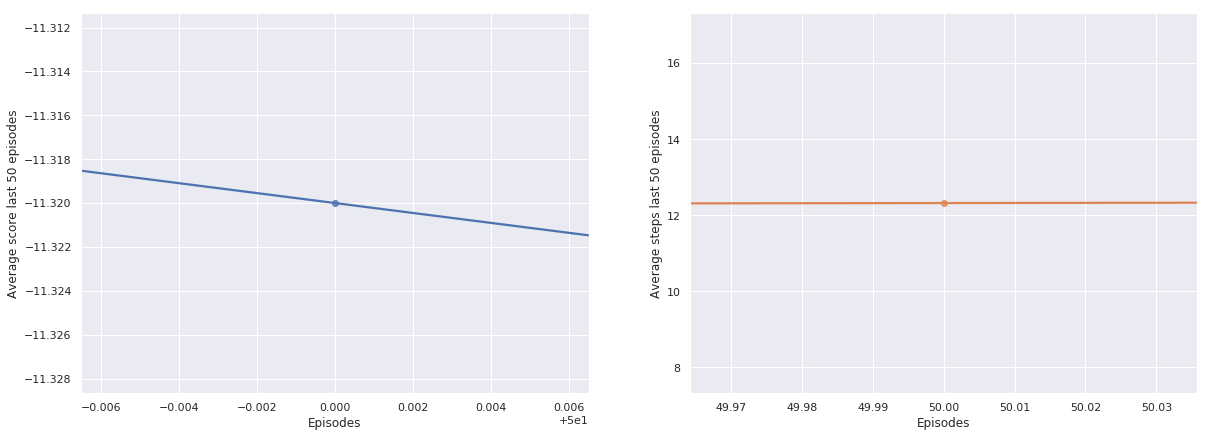

Min number of steps: 7
Max number of steps: 33


Min score: -32.0
Max score: -6.0


In [ ]:
plot_results(Config.rl.test_maze.checkpoint)


### Small Classic Maze

#### Training

In [ ]:
%%time

train_rl(
  'smallClassic',
  Config.rl.small_maze.checkpoint,
  Config.rl.small_maze.episodes,
  Config.rl.small_maze.tests
)

[QLearningAgent] training for 5000 games
[QLearningAgent] Episode 500 [reward=-513.692308]
[QLearningAgent] Episode 1000 [reward=-502.746043]
[QLearningAgent] Episode 1500 [reward=-512.278958]
[QLearningAgent] Episode 2000 [reward=-512.060807]
[QLearningAgent] Episode 2500 [reward=-521.000000]
[QLearningAgent] Episode 3000 [reward=-461.136061]
[QLearningAgent] Episode 3500 [reward=-514.017544]
[QLearningAgent] Episode 4000 [reward=-520.160251]
[QLearningAgent] Episode 4500 [reward=-521.000000]
[QLearningAgent] Episode 5000 [reward=-502.278958]
[QLearningAgent] training ended.
tcmalloc: large alloc 1610612736 bytes == 0x56097081e000 @  0x7f6061e811e7 0x56074fecc062 0x56074fef0569 0x56074fef44c6 0x56074fef44c6 0x56074fef44c6 0x56074fef44c6 0x56074fef44c6 0x56074fef44c6 0x56074fef44c6 0x56074fef44c6 0x56074fef44c6 0x56074fef44c6 0x56074fef44c6 0x56074fef44c6 0x56074fef44c6 0x56074fef44c6 0x56074fef44c6 0x56074fef44c6 0x56074fef44c6 0x56074fef44c6 0x56074fef44c6 0x56074fef44c6 0x56074fef44

#### Evaluation

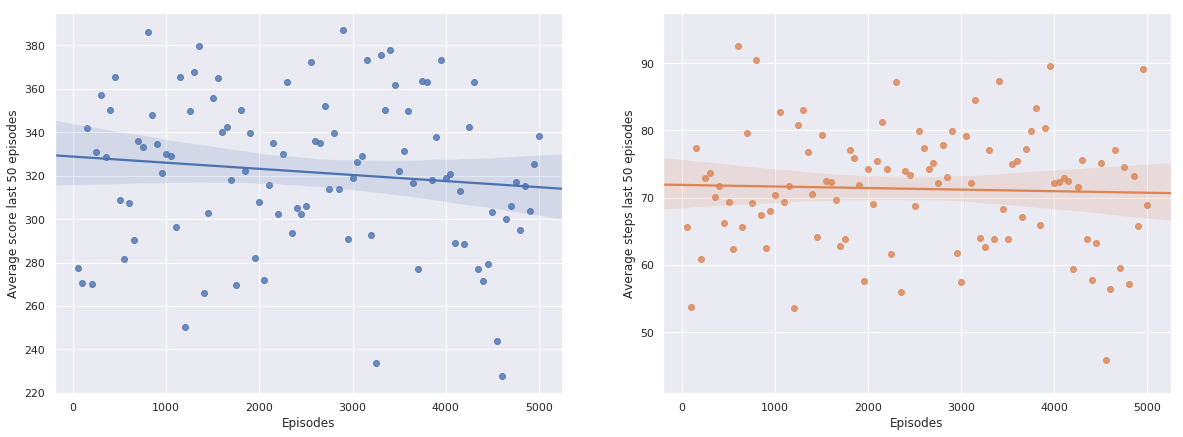

Min number of steps: 6
Max number of steps: 415


Min score: 12.0
Max score: 1241.0


In [ ]:
plot_results(Config.rl.small_maze.checkpoint)

### Medium Classic Maze

#### Training

In [ ]:
%%time

train_rl(
  'mediumClassic',
  Config.rl.medium_maze.checkpoint,
  Config.rl.medium_maze.episodes,
  Config.rl.medium_maze.tests
)

[QLearningAgent] training for 2000 games
[QLearningAgent] Episode 200 [reward=-518.785430]
[QLearningAgent] Episode 400 [reward=-511.000000]
[QLearningAgent] Episode 600 [reward=-511.068030]
[QLearningAgent] Episode 800 [reward=-519.000000]
[QLearningAgent] Episode 1000 [reward=-501.879183]
[QLearningAgent] Episode 1200 [reward=-519.638034]
[QLearningAgent] Episode 1400 [reward=-513.692308]
[QLearningAgent] Episode 1600 [reward=-518.785430]
[QLearningAgent] Episode 1800 [reward=-502.820006]
[QLearningAgent] Episode 2000 [reward=-513.508636]
[QLearningAgent] training ended.
[QLearningAgent] saving weights to /content/drive/MyDrive/datasets/MO444/assignment-3/checkpoints/rl/medium
tcmalloc: large alloc 1610612736 bytes == 0x55e4e7c86000 @  0x7fdfbdb481e7 0x55e321f38062 0x55e321f5c569 0x55e321f604c6 0x55e321f604c6 0x55e321f604c6 0x55e321f604c6 0x55e321f604c6 0x55e321f604c6 0x55e321f604c6 0x55e321f604c6 0x55e321f604c6 0x55e321f604c6 0x55e321f604c6 0x55e321f604c6 0x55e321f604c6 0x55e321f604

#### Evaluation

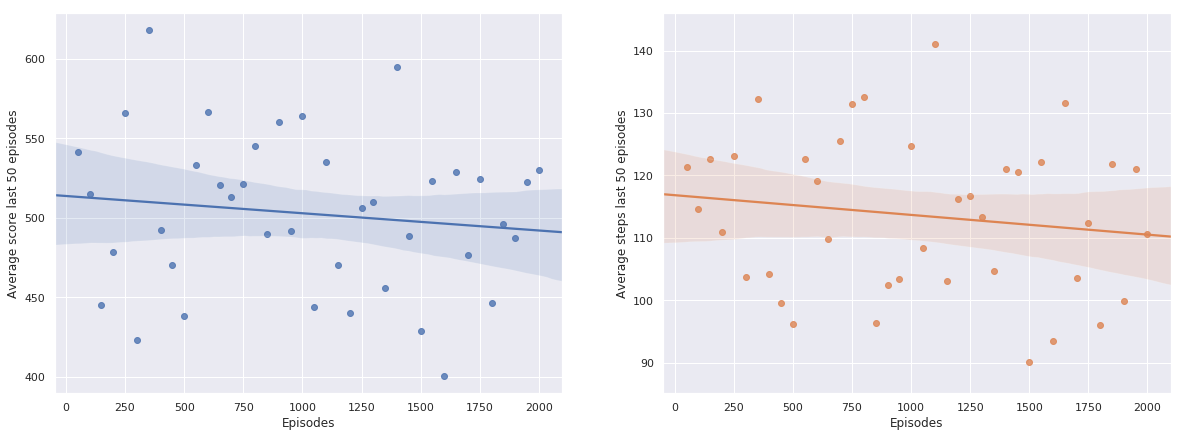

Min number of steps: 8
Max number of steps: 705


Min score: 2.0
Max score: 1522.0


In [ ]:
plot_results(Config.rl.medium_maze.checkpoint)

### Original Classic Maze

#### Training

In [ ]:
%%time

train_rl(
  'originalClassic',
  Config.rl.original_maze.checkpoint,
  Config.rl.original_maze.episodes,
  Config.rl.original_maze.tests
)

[QLearningAgent] training for 1000 games
[QLearningAgent] Episode 100 [reward=-510.699089]
[QLearningAgent] Episode 200 [reward=-508.635554]
[QLearningAgent] Episode 300 [reward=-509.964241]
[QLearningAgent] Episode 400 [reward=-510.818919]
[QLearningAgent] Episode 500 [reward=-498.224233]
[QLearningAgent] Episode 600 [reward=-502.598713]
[QLearningAgent] Episode 700 [reward=-509.082450]
[QLearningAgent] Episode 800 [reward=-524.001078]
[QLearningAgent] Episode 900 [reward=-517.881966]
[QLearningAgent] Episode 1000 [reward=-454.714568]
[QLearningAgent] training ended.
[QLearningAgent] saving weights to /content/drive/MyDrive/datasets/MO444/assignment-3/checkpoints/rl/original
tcmalloc: large alloc 1610612736 bytes == 0x563184e8e000 @  0x7fca550ca1e7 0x562e29a47062 0x562e29a6b569 0x562e29a6f4c6 0x562e29a6f4c6 0x562e29a6f4c6 0x562e29a6f4c6 0x562e29a6f4c6 0x562e29a6f4c6 0x562e29a6f4c6 0x562e29a6f4c6 0x562e29a6f4c6 0x562e29a6f4c6 0x562e29a6f4c6 0x562e29a6f4c6 0x562e29a6f4c6 0x562e29a6f4c6 

#### Evaluation

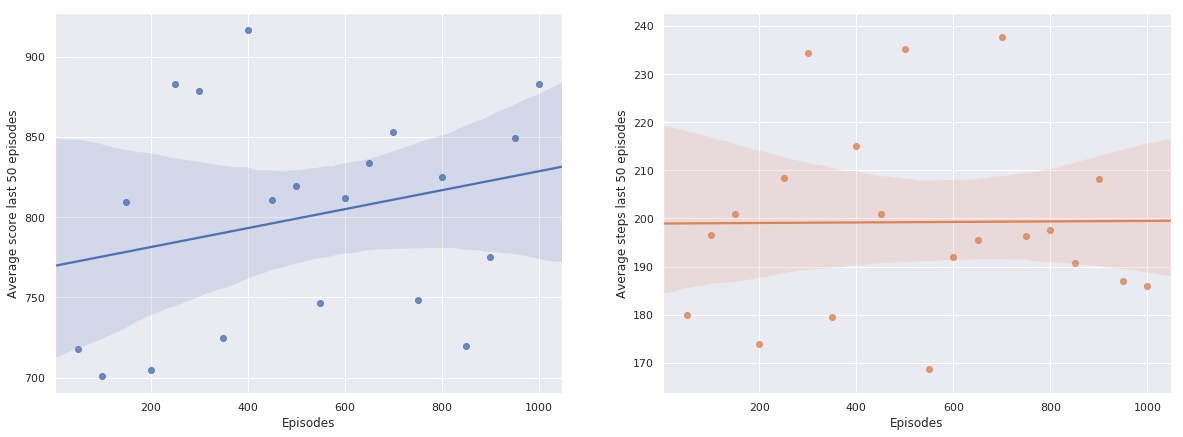

Min number of steps: 20
Max number of steps: 1293


Min score: 73.0
Max score: 2547.0


In [ ]:
plot_results(Config.rl.original_maze.checkpoint)

## Discussions

### Evolutionary Agent

* Small Classic Maze: During training, the solution candidate --- the highest scoring individual, with score of 510.2 --- was found around generation 22 (6,000th iteration of the game), and retained until end of evolution procedure.

  It is noticible, from the evolution graph over the Small Maze, that the score of the average individual  will stabilize after the 40th generation, showing little improvement. The greater variation of minimum score value is due to the constant replacement of the worst individuals during selection phase, replacing those by newborn (and unevaluated) individuals.

  This agent shown a average score of -105 during testing, loosing all of the games, but achieving a positive score in 45% of the games.

* Medium Classic Maze: The medium maze is considerably bigger than than the Small Maze, allowing for a higher number of states and positions ocupied by Pacman and the ghosts. As such, the game history is considerably longer, inducing a higher memory footprint for the whole program.
We compensate this memory requirement by running fewer iterations of the game (10,000, 50% less than Small Maze).

  The score of the average individual in the population stabilizes after the 30th generation, slighlty below the 200 score threshold. The minimum fittness value in each generation presents an even stronger variation, when compared to the trend found in Small Maze.

  This agent shows an average test score of 125.5, achieving a positive score in 80% of the games.
Notwithsanding, it still lost all of the games.

* Original Classic Maze: we reduce the number of game iterations for the Original Classic Maze to 4,600. This number approximately correspond to the maximum number of iterations that can fit into the memory constrains imposed by Colab Pro High-RAM instance (~30 GB), and it was found empirically.
16 complete generations were evaluated in the process, which took approx. one hour to complete.

  The fittest candidate was found at the 4,595th iteration of the game (10th generation), after which the average score among the individuals seem to stabilize. However, considering that few generations were evaluated, we expect to have better results if higher RAM levels were available.

  The best individual had a test score of 33.8.
Once again, it achieved a positive score in 80% of the games it played, but lost all of them.

### RL Agent

* Small Classic Maze: The agent was trained for 5000 iterations of the game.

  During test, it achieved an average score of 415.6 and a positive score in 7 out of 10 games.
It also has won 30% of the games it played.

* Medium Classic Maze: The RL agent was trained for 2,000 iterations of the game over the Medium Classic Maze. Similarly to our Evolutionary Agent, memory constraints prevented us from training for longer periods.

  During testing, the agent played 10 games, achieving an average score of 1005.3 points. The agent obtained a positive score in 70% of the games, and won 60% of them.

* Original Classic Maze: Being the largest map, we were limited to run the game for only 1,000 iterations. The regression line over the average score graph for the RL-based agent show a positive tendency, indicating an overall increase in score during the first 1,000 iterations.

  During testing, 10 games were played and the agent obtained an average score of 1261.9 points. The agent obtained positive scores in 9 out of 10, but won a single game.

## Final Considerations

The agent based on Reinforcement-Learning consistently showed a better results than the agent based on Genetic Algorithm, by both winning more games and presenting a higher average score in test games.

Our evolutionary solution could be further improved by (a) adding more contextual information (developing more features) into the system; (b) considering non-linear decision functions (more than a single layer); and (c) leveraging a computing instance with higher RAM available. As for our RL solution, we envision that a more compact and digested representation of the world could be beneficial in reducing the size of the q-values table, allowing for more interations to be run and more focused learning to be performed.